### Notebook to Run Individual *in silico* JCVI-syn3A Simulations Serially (with example analysis)

In [1]:
# Import Lattice Microbes Software Suite (https://github.com/zanert2/Lattice_Microbes) modules
import lm

In [2]:
### Set possible runtime and analysis arguments
time = 4 # minutes
restartTime = 1 # minutes

In [3]:
## Use bash magic to run the cells
%%bash

# Simulation Arguments
# -procid, the processID (i.e. 1,2,3 ...)
# -t, the total simulation time (in minutes, cell cycle = 120 minutes to ensure simulation of full cell cycles)
# -rs, the restart time (in minutes, default = 1)

python3 MinCell_CMEODE_mpi.py -procid 1 -t 1 #args (time should be 1 minute here, to set initial conditions)
python3 MinCell_restart.py -procid 1 -t 5 -rs 1 #args

### Some simple Analysis to plot out individual species

Documentation for analysis unctionality can be accessed via **'?myMethod'**

*e.g* ?pp.openLMFile 

to return a docstring

In [5]:
# Import needed modules
import numpy as np
import sys
import os
import glob
import lm as lm
from pyLM import *

from pySTDLM import PostProcessing as pp

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
pp.openLMFile?

In [6]:
times=np.arange(0,time,1)
numSims=1

In [7]:
# Sets sims folder to your current working directory ... you can modify this if needed
os.chdir('..')
simsFolder = os.getcwd()+'/simulations/'
fn='out-1.lm'# siingle simulation file

In [29]:
# Get a list of all chemical species (genes, RNA, proteins etc.) tracked in the simulation
fh = pp.openLMFile(simsFolder+fn)
spec_list=pp.getSpecies(fh)

In [18]:
# Check that we are in the correct directory
%%bash
pwd

/home/hodur/software/Minimal_Cell/CME_ODE/simulations


In [11]:
# Get traces of all cells
def getTraces(sL,numSims,times):
    fileList=[]
    traceArr = np.zeros((numSims,len(sL),len(times)))
    os.chdir(simsFolder)
    for i, my_file in enumerate(glob.glob("*.csv")):
        print(my_file)
        fileList.append(my_file)
        df = pd.read_csv(str(my_file),header=0)
        for j,time in enumerate(times):
            if (j == 0):
                startVal = 0
                endVal=len(sL)
            else:
                startVal=((len(sL)+1)*j)
                endVal=(len(sL)+1)*(j+1)-1
            traceArr[i,:,j] = df[startVal:endVal]['0.0'][:]
    return traceArr,fileList

In [12]:
ta,fL = getTraces(spec_list,numSims,times)

rep-1.csv
sv is:  0
ev is:  2662
sv is:  2663
ev is:  5325
sv is:  5326
ev is:  7988
sv is:  7989
ev is:  10651


In [13]:
# Set beginning and ending times for plottting
startTime=0
endTime=times[-1]

In [14]:
zeros = np.zeros((numSims,len(spec_list),len(times)))

75
[[3.65401488 2.96753036 3.62963083 3.14965733]]


Text(0.5, 1.0, "['M_atp_c']")

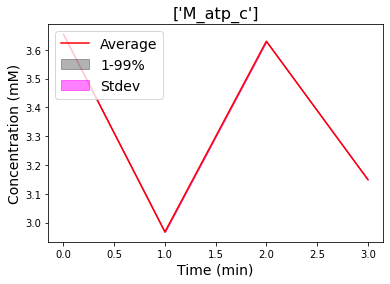

In [17]:
# Plot a chemical species concentration
species_list = ['M_atp_c']
times = np.arange(startTime,endTime+1,1)

specInd = spec_list.index(species_list[0])
vInd=spec_list.index('CellV')
print(specInd)
# 1e-19 conversion factor since 'Volume' is stored as in 10^-19 L to give values of 335 for IC etc.
conc = ta[:,specInd,startTime:endTime+1]*1000.0/(ta[:,vInd,startTime:endTime+1]*1e-19*6.022e23)

plt.fill_between(times[:],np.percentile(conc,1,axis=0),np.percentile(conc,99,axis=0),alpha=0.3,label='1-99%',color='black')
plt.fill_between(times[:],np.average(conc,axis=0)+np.std(conc,axis=0),np.maximum(np.average(conc,axis=0)-np.std(conc,axis=0),zeros[0,0,:]),alpha=0.5,label='Stdev',color='magenta')
plt.plot(times[:],np.median(conc,axis=0),label='Average',color='red')

plt.ylabel('Concentration (mM)',fontsize=14)
plt.xlabel('Time (min)',fontsize=14)
#plt.ylim(0,5)
plt.legend(fontsize=14,loc='upper left')
plt.title(species_list,fontsize=16)

### Plot out Particle Number instead of concentration

For example, let's look at the enzyme Fructose Bisphosphate Aldolase (*fba*, /JCVISYN3A_0131).

As we can see, even after a few minutes several copies of this main glycolysis pathway enzyme are translated.

In [21]:
# Get particle counts
def getParts(ta,specInd,startTime,endTime):
    parts=ta[:,specInd,startTime:endTime+1]
    return parts

In [27]:
# Get average minus standard deviation
def sdMinus(conc):
    arr=np.maximum(np.average(conc,axis=0)-np.std(conc,axis=0),zeros[0,0,:])
    return arr

Text(0.5, 1.0, "['M_PTN_JCVISYN3A_0131_c']")

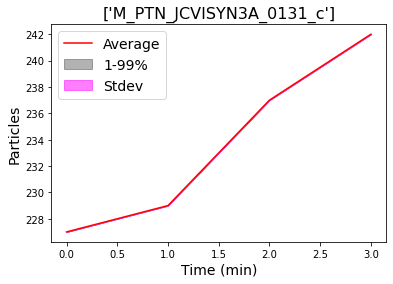

In [28]:
# Plot a chemical species in number of particles
species_list = ['M_PTN_JCVISYN3A_0131_c']
times = np.arange(startTime,endTime+1,1)

specInd = spec_list.index(species_list[0])
conc = getParts(ta,specInd,startTime,endTime)

plt.fill_between(times[:],np.percentile(conc,1,axis=0),np.percentile(conc,99,axis=0),alpha=0.3,label='1-99%',color='black')
plt.fill_between(times[:],np.average(conc,axis=0)+np.std(conc,axis=0),sdMinus(conc),alpha=0.5,label='Stdev',color='magenta')
plt.plot(times[:],np.average(conc,axis=0),label='Average',color='red')

plt.ylabel('Particles',fontsize=14)
plt.xlabel('Time (min)',fontsize=14)
plt.legend(fontsize=14,loc='upper left')
plt.title(species_list,fontsize=16)